In [2]:
import sys
sys.path.append('../../scripts/')
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-talk')
from load_SAIdata import Cases
from xarray_funcs import wmean
import cmocean
import cartopy.crs as ccrs
from dask.distributed import LocalCluster, Client
from dask.diagnostics import ProgressBar
import numpy as np
import xarray as xr
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
VAR = 'PRECT'
DASK_NUM = 1e6 # optimal number of element in dask chunk

In [3]:
# initiate dask cluster for parallel computing
cluster = LocalCluster(n_workers=8) #n_workers=16, threads_per_worker=1, memory_limit="14GiB", processes=True)
client = Client(cluster)
cluster, client

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/contextlib.py:144: UserWarning: Creating scratch directories is taking a surprisingly long time. (2.83s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


(LocalCluster(30e66d4e, 'tcp://127.0.0.1:39437', workers=8, threads=16, memory=28.00 GiB),
 <Client: 'tcp://127.0.0.1:39437' processes=8 threads=16, memory=28.00 GiB>)

In [4]:
Cases.cases

{'lres.spinup': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f09_g16/spinup_pd_maxcores_f09_g16/OUTPUT',
 'lres.sai20': '/projects/0/nwo2021025/archive/lres_b.e10.B2000_CAM5.f09_g16.feedforward.001',
 'lres.sai': '/projects/0/nwo2021025/archive/lres_b.e10.B2000_CAM5.f09_g16.feedforward_2050.001',
 'mres.cnt': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f05_t12/rcp8.5_co2_f05_t12',
 'mres.sai': '/projects/0/nwo2021025/archive/mres_b.e10.B2000_CAM5.f05_t12.001',
 'hres.ref.1': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f02_t12/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.001/OUTPUT',
 'hres.ref.2': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f02_t12/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.002/OUTPUT',
 'hres.ref.3': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f02_t12/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.003/OUTPUT',
 'hres.ref.4': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f02_t12/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_200

In [5]:
%%time

# opening and preprocessing data
cam = {}
tags = list(Cases.cases)[1:] # exclude spinup
for tag in tags:
    if 'hres' not in tag:
        continue
    dsi = Cases(tag).select('atm','h0').open_mfdataset(verbose=False) # open data
    dsi = dsi.assign_coords({'time':dsi.time_bnds.mean('nbnd', keep_attrs=True)}) # set time to mid of interval
    valid_times = dsi.time.groupby('time.year').count().sel(year=dsi.time.dt.year) == 12
    tagparts = tag.split('.')
    tagparts.insert(2,'h0')
    tag = '.'.join(tagparts)
    cam[tag] = dsi.isel(time=valid_times) # drop years with less than 12 values
    print(f'{tag}: {cam[tag].time.size/12} complete years')
    
# # repeat for yearly averages from mres.control
# tags = ['mres.cnt']
# for tag in tags:
#     dsi = Cases(tag).select('atm','h0.avgYYYY').open_mfdataset(verbose=False) # open data
#     dsi = dsi.assign_coords({'time':dsi.time_bnds.mean('nbnd', keep_attrs=True)}) # set time to mid of interval
#     #valid_times = dsi.time.groupby('time.year').count().sel(year=dsi.time.dt.year) == 12
#     tagparts = tag.split('.')
#     tagparts.insert(2,'h0_avgYYYY')
#     tag = '.'.join(tagparts)
#     cam[tag] = dsi #.isel(time=valid_times) # drop years with less than 12 values
#     print(f'{tag}: {cam[tag].time.size} complete years')

hres.ref.h0.1: 10.0 complete years
hres.ref.h0.2: 5.0 complete years
hres.ref.h0.3: 5.0 complete years
hres.ref.h0.4: 5.0 complete years
hres.ref.h0.5: 5.0 complete years
hres.ref.h0.6: 5.0 complete years
hres.cnt.h0.1: 5.0 complete years
hres.cnt.h0.2: 5.0 complete years
hres.cnt.h0.3: 5.0 complete years
hres.cnt.h0.4: 5.0 complete years
hres.cnt.h0.5: 5.0 complete years
hres.cnt.h0.6: 5.0 complete years
hres.sai.h0.1: 5.0 complete years
hres.sai.h0.2: 5.0 complete years
hres.sai.h0.3: 5.0 complete years
hres.sai.h0.4: 5.0 complete years
hres.sai.h0.5: 5.0 complete years
hres.sai.h0.6: 5.0 complete years
CPU times: user 49.8 s, sys: 3.66 s, total: 53.5 s
Wall time: 58 s


In [3]:
# files = {
#     'ref':[
#         'b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.001.cam2.h0.2002-12_2012-12.json',
#         'b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.002.cam2.h0.2002-12_2007-12.json',
#         'b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.003.cam2.h0.2002-12_2007-12.json',
#         'b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.004.cam2.h0.2002-12_2007-12.json',
#         'b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.005.cam2.h0.2002-12_2008-02.json',
#     ],
#     'cnt':[
#         'b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2092-12.001.cam2.h0.2092-12_2097-12.json',
#         'b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2092-12.002.cam2.h0.2092-12_2097-12.json',
#         'b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2092-12.003.cam2.h0.2092-12_2098-01.json',
#         'b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2092-12.004.cam2.h0.2092-12_2097-12.json',
#         'b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2092-12.005.cam2.h0.2092-12_2097-12.json',
#     ],
#     'sai':[
#         'hres_b.e10.B2000_CAM5.f02_t12.started_2092-12.001.cam2.h0.2092-12_2097-12.json',
#         'hres_b.e10.B2000_CAM5.f02_t12.started_2092-12.001.cam2.h0.2092-12_2097-12.json',
#         'hres_b.e10.B2000_CAM5.f02_t12.started_2092-12.001.cam2.h0.2092-12_2097-12.json',
#         'hres_b.e10.B2000_CAM5.f02_t12.started_2092-12.001.cam2.h0.2092-12_2097-12.json',
#         'hres_b.e10.B2000_CAM5.f02_t12.started_2092-12.001.cam2.h0.2092-12_2097-12.json',
#     ]
# }
# ds = {tag: [xr.open_dataset(f"~/kerchunk/{files[tag][i]}", engine='kerchunk') for i in range(5)] for tag in files}


In [7]:
%%time
cam['ref'] = xr.concat([cam[tag].sel(time=slice('2003','2007')) for tag in cam if 'hres.ref' in tag], dim='ens')
cam['cnt'] = xr.concat([cam[tag].sel(time=slice('2093','2097')) for tag in cam if 'hres.cnt' in tag], dim='ens')
cam['sai'] = xr.concat([cam[tag].sel(time=slice('2093','2097')) for tag in cam if 'hres.sai' in tag], dim='ens')


CPU times: user 5.63 s, sys: 639 ms, total: 6.27 s
Wall time: 7.34 s


In [8]:
%%time
TMQokt = {tag: cam[tag].TMQ.where(cam[tag].time.dt.month==10, drop=True).mean(('time','ens')).persist() 
          for tag in ['ref','cnt','sai']}

CPU times: user 58.6 ms, sys: 1.02 ms, total: 59.6 ms
Wall time: 61.9 ms


In [9]:
%%time
TMQmar = {tag: cam[tag].TMQ.where(cam[tag].time.dt.month==3, drop=True).mean(('time','ens')).persist()
          for tag in ['ref','cnt','sai']}

CPU times: user 76 ms, sys: 67 µs, total: 76.1 ms
Wall time: 75.8 ms


Text(0.5, 1.0, 'oktober Ref')

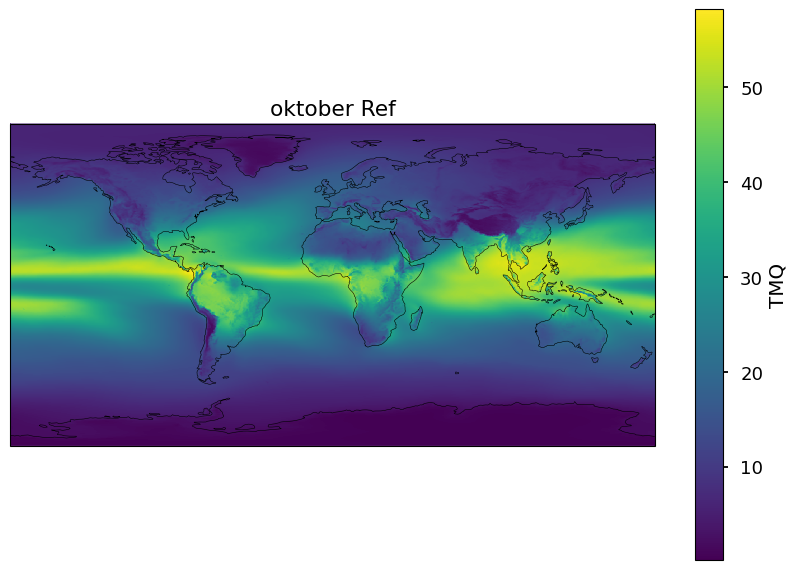

In [10]:
ax = plt.axes(projection = ccrs.PlateCarree())
(TMQokt['ref']).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('oktober Ref')

Text(0.5, 1.0, 'oktober RCP - Ref')

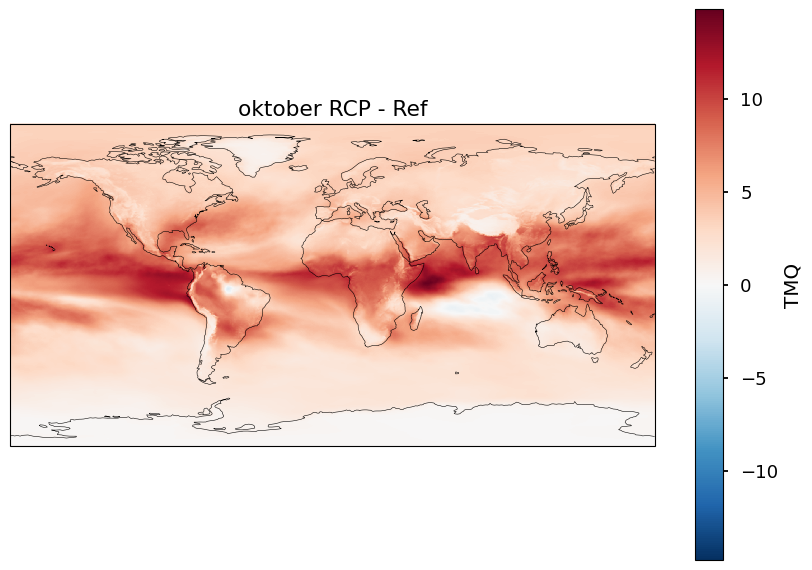

In [11]:
ax = plt.axes(projection = ccrs.PlateCarree())
(TMQokt['cnt'] - TMQokt['ref']).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('oktober RCP - Ref')

Text(0.5, 1.0, 'oktober SAI - Ref')

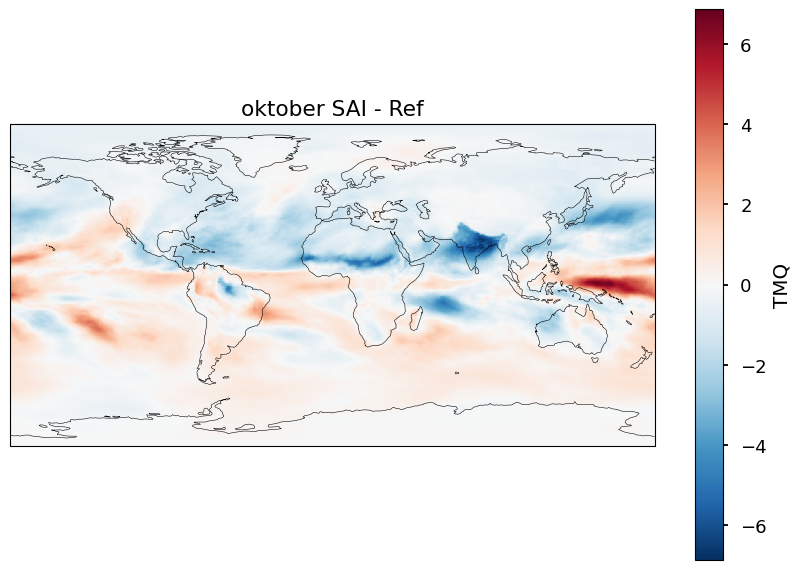

In [12]:
ax = plt.axes(projection = ccrs.PlateCarree())
(TMQokt['sai'] - TMQokt['ref']).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('oktober SAI - Ref')

Text(0.5, 1.0, 'march Ref')

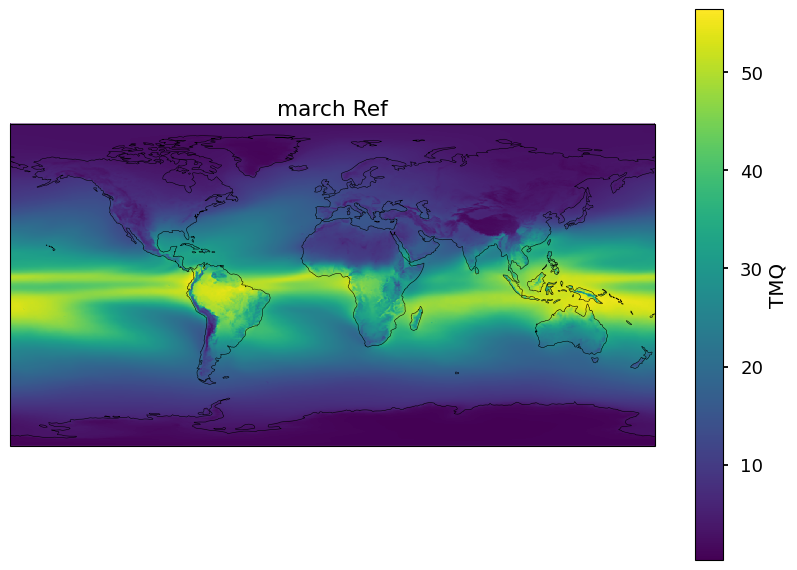

In [14]:
ax = plt.axes(projection = ccrs.PlateCarree())
(TMQmar['ref']).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('march Ref')

Text(0.5, 1.0, 'march RCP - Ref')

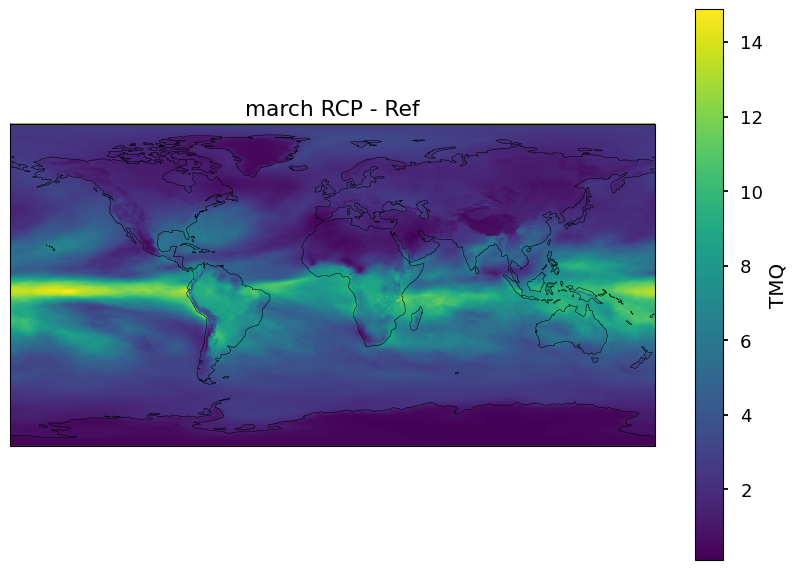

In [15]:
ax = plt.axes(projection = ccrs.PlateCarree())
(TMQmar['cnt'] - TMQmar['ref']).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('march RCP - Ref')

Text(0.5, 1.0, 'march SAI - Ref')

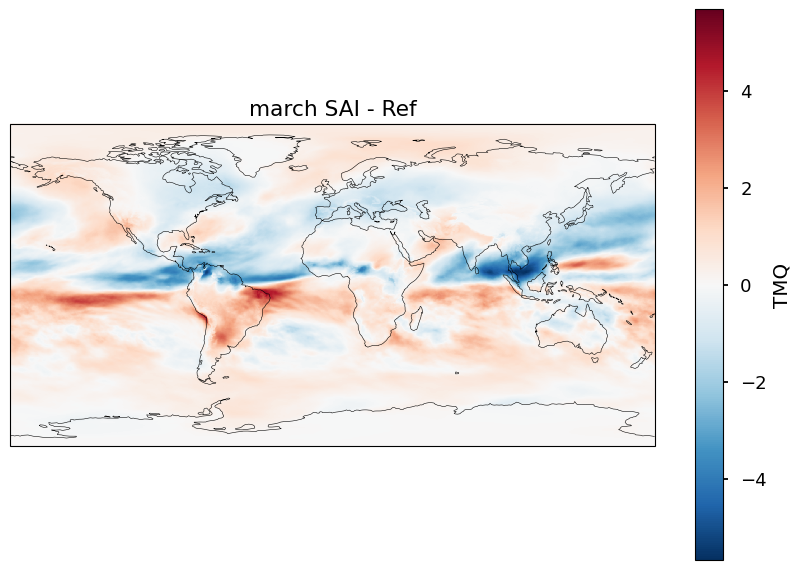

In [16]:
ax = plt.axes(projection = ccrs.PlateCarree())
(TMQmar['sai'] - TMQmar['ref']).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('march SAI - Ref')

Text(-205, 0, 'October')

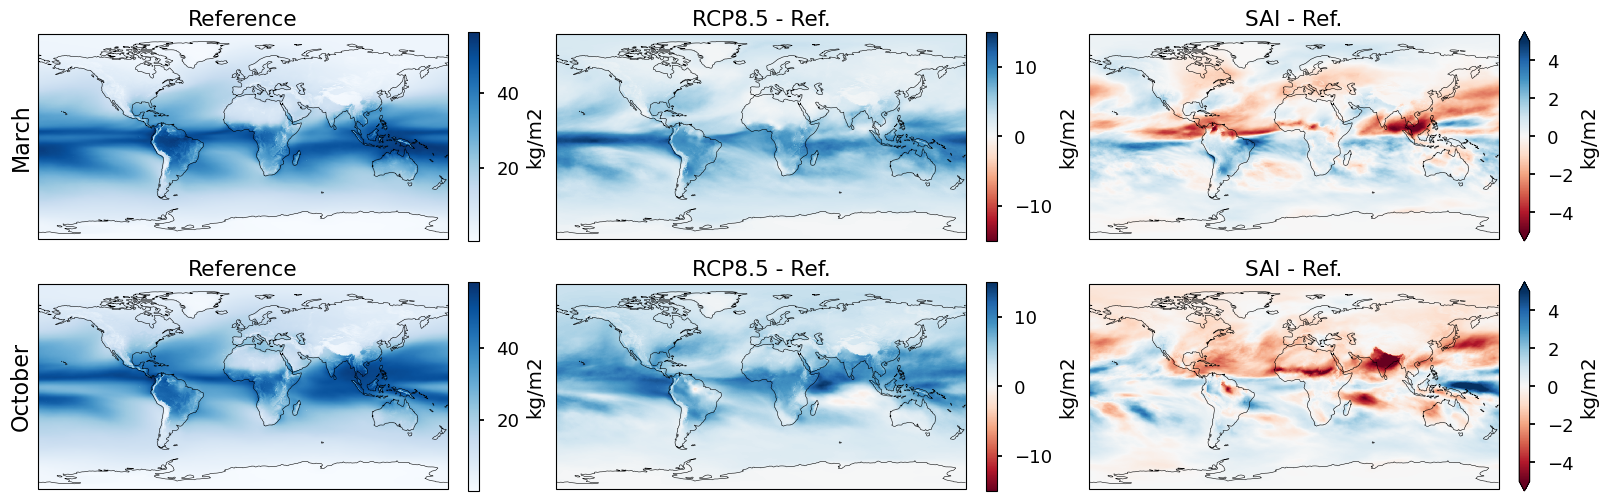

In [40]:
crs = ccrs.PlateCarree()
kwargs = {'transform':crs, 'cbar_kwargs':{'shrink':1, 'label':cam['ref'].TMQ.units}}

fig,axs = plt.subplots(2,3,figsize=(16,5),sharex=True, sharey=True, layout='constrained', subplot_kw={'projection':crs})

ax = axs[0,0]
TMQmar['ref'].plot(ax=ax, cmap='Blues', **kwargs)
ax.set_title('Reference')
ax.set_xlabel('March')
ax.coastlines()
ax = axs[0,1]
(TMQmar['cnt'] - TMQmar['ref']).plot(ax=ax, cmap='RdBu', norm=mcolors.CenteredNorm(halfrange=15), **kwargs)
ax.set_title('RCP8.5 - Ref.')
ax.coastlines()
ax = axs[0,2]
(TMQmar['sai'] - TMQmar['ref']).plot(ax=ax, cmap='RdBu', norm=mcolors.CenteredNorm(halfrange=5), **kwargs)
ax.set_title('SAI - Ref.')
ax.coastlines()

ax = axs[1,0]
TMQokt['ref'].plot(ax=ax, cmap='Blues', **kwargs)
ax.set_title('Reference')
ax.set_xlabel('March')
ax.coastlines()
ax = axs[1,1]
(TMQokt['cnt'] - TMQokt['ref']).plot(ax=ax, cmap='RdBu', norm=mcolors.CenteredNorm(halfrange=15), **kwargs)
ax.set_title('RCP8.5 - Ref.')
ax.coastlines()
ax = axs[1,2]
(TMQokt['sai'] - TMQokt['ref']).plot(ax=ax, cmap='RdBu', norm=mcolors.CenteredNorm(halfrange=5), **kwargs)
ax.set_title('SAI - Ref.')
ax.coastlines()

axs[0,0].text(-205,0, "March", rotation=90, fontsize=16, va='center')
axs[1,0].text(-205,0,"October", rotation=90, fontsize=16, va='center')

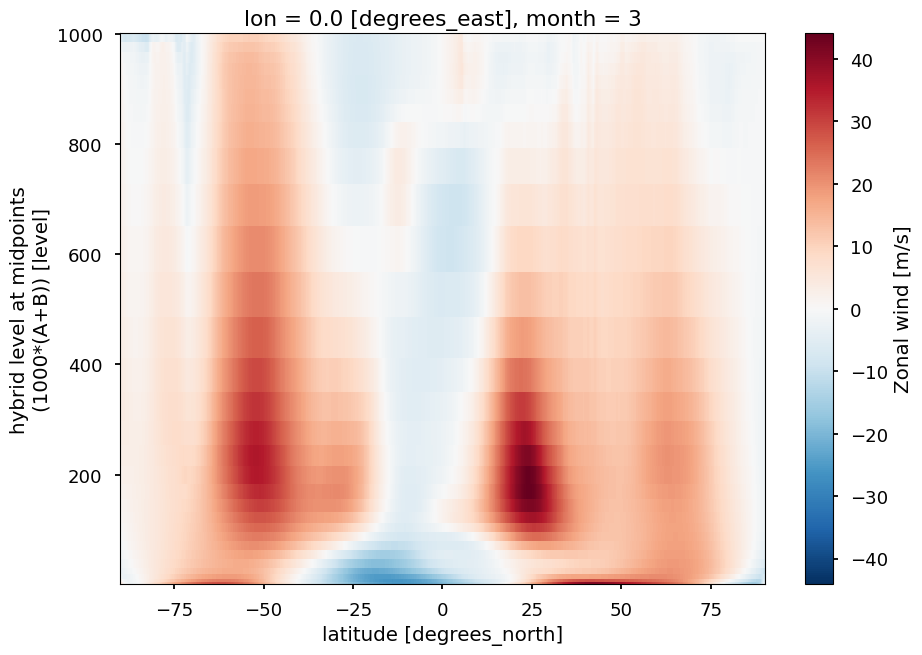

## CAM H0 -- full time series

In [9]:
%%time

# calculate global mean
VARgm = {}
for tag in cam:
    ds = cam[tag]
    ds = ds.chunk({'time':int(DASK_NUM/(ds.lat.size*ds.lon.size))})
    dsm = wmean(ds[VAR], ds.gw, ('lat','lon'), keep_attrs=True)
    dsm = dsm.compute()
    VARgm[tag] = dsm
    
# calculate average monthly seasonal cycle
VARmgm = {}
for tag in VARgm:
    if 'h0_avgYYYY' in tag.split('.'):
        VARmgm[tag] = VARgm[tag]
        continue
    VARmgm[tag] = VARgm[tag].groupby('time.month').mean()

# take ensemble average of first five members
for tag in ['hres.ref','hres.cnt','hres.sai']:
    VARmgm[f'{tag}.h0'] = xr.concat([VARmgm[f'{tag}.h0.{i}'] for i in range(1,6)], dim='number').mean('number', keep_attrs=True)
    
# calculate annual mean
annmeans = {}
for tag in VARgm:
    if 'avgYYYY' in tag:
        continue
    w = cam[tag].time_bnds.diff('nbnd').squeeze().astype('int') # month weights
    w = w * w.size/w.sum()
    if tag == 'mres.cnt.h0':
        w[0] = w[12] # time_bnds on first step is less than 31 days, fix manually
    avgtag = tag.replace('h0','h0_avgYYYY')
    if avgtag in VARgm:
        continue # don't overwrite annual mean datasets
    annmeans[avgtag] =  (VARgm[tag]*w).coarsen(time=12).mean(keep_attrs=True)
for avgtag in annmeans:
    VARgm[avgtag] = annmeans[avgtag]

CPU times: user 14.7 s, sys: 997 ms, total: 15.7 s
Wall time: 45.8 s


In [10]:
# comment out lines below to exclude from plot

kwargs = {
    'lres.sai20.h0': dict(label='LR-SAI2020', lw=1.5, c='lightgray'),
    'lres.sai.h0': dict(label='LR-SAI2050', lw=1.5, c='lightgray'),
    'mres.cnt.h0': dict(label='MR-Control', lw=1.5, c='orangered'),
    'mres.sai.h0': dict(label='MR-SAI2050', lw=1.5, c='dodgerblue'),
    'hres.ref.h0.1': dict(label='HR-Reference', lw=0.5, c='g'),
    'hres.ref.h0.2': dict(label=None, lw=0.5, c='g'),
    'hres.ref.h0.3': dict(label=None, lw=0.5, c='g'),
    'hres.ref.h0.4': dict(label=None, lw=0.5, c='g'),
    'hres.ref.h0.5': dict(label=None, lw=0.5, c='g'),
    'hres.ref.h0.6': dict(label=None, lw=0.5, c='g'),
    'hres.cnt.h0.1': dict(label='HR-Control', lw=0.5, c='firebrick'),
    'hres.cnt.h0.2': dict(label=None, lw=0.5, c='firebrick'),
    'hres.cnt.h0.3': dict(label=None, lw=0.5, c='firebrick'),
    'hres.cnt.h0.4': dict(label=None, lw=0.5, c='firebrick'),
    'hres.cnt.h0.5': dict(label=None, lw=0.5, c='firebrick'),
    'hres.cnt.h0.6': dict(label=None, lw=0.5, c='firebrick'),
    'hres.sai.h0.1': dict(label='HR-SAI2050', lw=0.5, c='navy'),
    'hres.sai.h0.2': dict(label=None, lw=0.5, c='navy'),
    'hres.sai.h0.3': dict(label=None, lw=0.5, c='navy'),
    'hres.sai.h0.4': dict(label=None, lw=0.5, c='navy'),
    'hres.sai.h0.5': dict(label=None, lw=0.5, c='navy'),
    'hres.sai.h0.6': dict(label=None, lw=0.5, c='navy'),
}

kwargs_avg = {
    'lres.sai20.h0_avgYYYY': dict(label='LR-SAI2020', lw=2.5, c='lightgray'),
    'lres.sai.h0_avgYYYY': dict(label='LR-SAI2050', lw=2.5, c='lightgray'),
    'mres.cnt.h0_avgYYYY': dict(label='MR-Control', lw=2.5, c='orangered'),
    'mres.sai.h0_avgYYYY': dict(label='MR-SAI2050', lw=2.5, c='dodgerblue'),
    'hres.ref.h0_avgYYYY.1': dict(label='HR-Reference', lw=1.5, c='g'),
    'hres.ref.h0_avgYYYY.2': dict(label=None, lw=1.5, c='g'),
    'hres.ref.h0_avgYYYY.3': dict(label=None, lw=1.5, c='g'),
    'hres.ref.h0_avgYYYY.4': dict(label=None, lw=1.5, c='g'),
    'hres.ref.h0_avgYYYY.5': dict(label=None, lw=1.5, c='g'),
    'hres.ref.h0_avgYYYY.6': dict(label=None, lw=1.5, c='g'),
    'hres.cnt.h0_avgYYYY.1': dict(label='HR-Control', lw=1.5, c='firebrick'),
    'hres.cnt.h0_avgYYYY.2': dict(label=None, lw=1.5, c='firebrick'),
    'hres.cnt.h0_avgYYYY.3': dict(label=None, lw=1.5, c='firebrick'),
    'hres.cnt.h0_avgYYYY.4': dict(label=None, lw=1.5, c='firebrick'),
    'hres.cnt.h0_avgYYYY.5': dict(label=None, lw=1.5, c='firebrick'),
    'hres.cnt.h0_avgYYYY.6': dict(label=None, lw=1.5, c='firebrick'),
    'hres.sai.h0_avgYYYY.1': dict(label='HR-SAI2050', lw=1.5, c='navy'),
    'hres.sai.h0_avgYYYY.2': dict(label=None, lw=1.5, c='navy'),
    'hres.sai.h0_avgYYYY.3': dict(label=None, lw=1.5, c='navy'),
    'hres.sai.h0_avgYYYY.4': dict(label=None, lw=1.5, c='navy'),
    'hres.sai.h0_avgYYYY.5': dict(label=None, lw=1.5, c='navy'),
    'hres.sai.h0_avgYYYY.6': dict(label=None, lw=1.5, c='navy'),
}

Text(0.5, 1.0, 'annual mean')

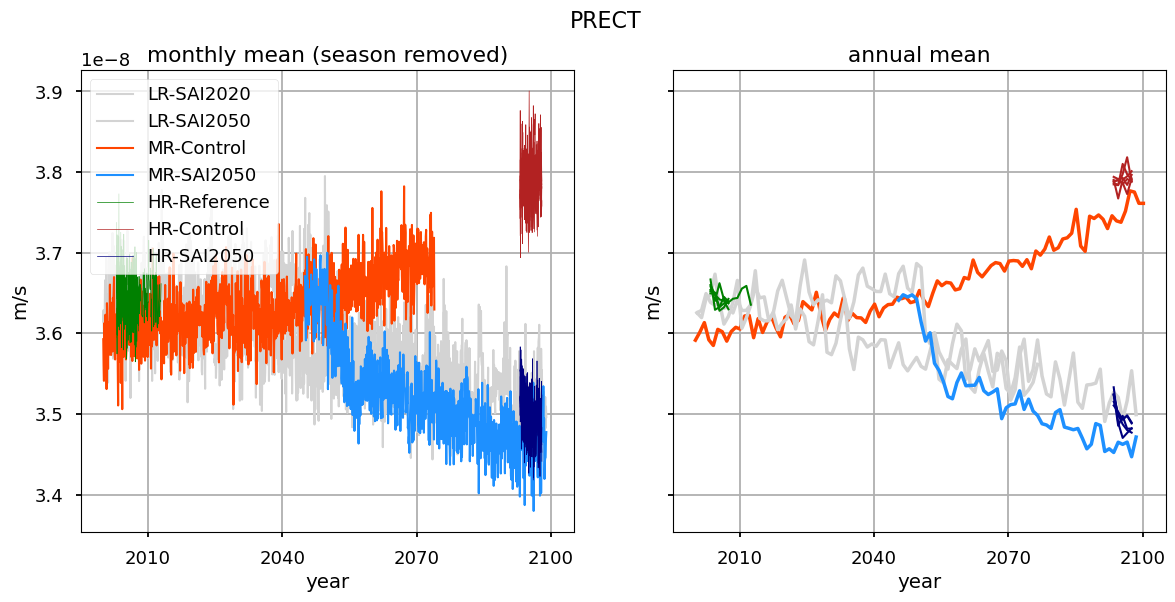

In [12]:
FAC = 

fig, axs = plt.subplots(1,2, figsize=(14,6), sharex=True, sharey=True)
fig.suptitle('PRECT', fontsize=16)

# monthly mean plot
ax = axs[0]
# ax.axhline(288.93796, xmin=0.05, xmax=0.95, ls='--', c='lightgray')
# ax.axhline(288.09713, xmin=0.05, xmax=0.95, ls='--', c='dodgerblue')
for tag in VARgm: # only loop through experiments above
    if tag not in kwargs:
        continue
    shorttag = '.'.join(tag.split('.')[:3]) # tag without ensemble member
    gb = VARmgm[shorttag]
    (VARgm[tag].groupby('time.month')-(gb-gb.mean())).plot(ax=ax, **kwargs[tag])
ax.grid()
ax.set_xlabel('year')
ax.set_ylabel(VARgm['mres.cnt.h0'].units)
ax.set_title('monthly mean (season removed)')
ax.legend()

# annual mean plot
ax = axs[1]
#ax.axhline(288.93796, xmin=0.05, xmax=0.95, ls='--', c='lightgray')
#ax.axhline(288.09713, xmin=0.05, xmax=0.95, ls='--', c='dodgerblue')
for tag in VARgm: # only loop through experiments above
    if tag not in kwargs_avg:
        continue
    shorttag = '.'.join(tag.split('.')[:3]) # tag without ensemble member
    VARgm[tag].plot(ax=ax, **kwargs_avg[tag])
ax.grid()
ax.set_xlabel('year')
ax.set_ylabel(VARgm['mres.cnt.h0'].units)
ax.set_title('annual mean')
#ax.legend()

## CAM h0 -- maps

In [4]:
for tag in cam:
    cam[tag] = cam[tag].isel(time=[0,3,6,9], lat=slice(None,None,4), lon=slice(None,None,4))

In [6]:
def seasonal_average(ds):
    w = ds.time.dt.days_in_month
    w = w.groupby('time.season') / w.groupby('time.season').sum()
    return (ds * w).groupby("time.season").sum(dim="time")

In [7]:
cam_EM = {
    'ref': xr.concat([cam[f'hres.ref.h0.{i}'][[VAR,'time_bnds','gw']].sel(time=slice('2003','2007')) for i in range(1,6)], dim='number').mean('number', keep_attrs=True),
    'cnt': xr.concat([cam[f'hres.cnt.h0.{i}'][[VAR,'time_bnds','gw']].sel(time=slice('2093','2097')) for i in range(1,6)], dim='number').mean('number', keep_attrs=True),
    'sai': xr.concat([cam[f'hres.sai.h0.{i}'][[VAR,'time_bnds','gw']].sel(time=slice('2093','2097')) for i in range(1,6)], dim='number').mean('number', keep_attrs=True),
}

ds = cam_EM['ref']
print(tag, ds.sizes)
print(f"Data should be divided in {(ds.time.size*ds.lat.size*ds.lon.size)/DASK_NUM:.0f} chunks for optimal performance.")

mres.cnt.h0_avgYYYY Frozen({'time': 60, 'lat': 768, 'lon': 1152})
Data should be divided in 53 chunks for optimal performance.


In [9]:
%%time
#chunks = {'time':4} 
chunks = {'lat':64, 'lon':96} # 12 x 12 chunks
#cam_EMTM = {tag: seasonal_average(cam_EM[tag].chunk(chunks)) for tag in cam_EM}
cam_EMTM = {tag: seasonal_average(cam_EM[tag].chunk(chunks)).compute() for tag in cam_EM}

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 202.66 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 202.66 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 202.66 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 6.06 s, sys: 1.03 s, total: 7.1 s
Wall time: 7.3 s


CPU times: user 5.01 s, sys: 266 ms, total: 5.28 s
Wall time: 5.14 s


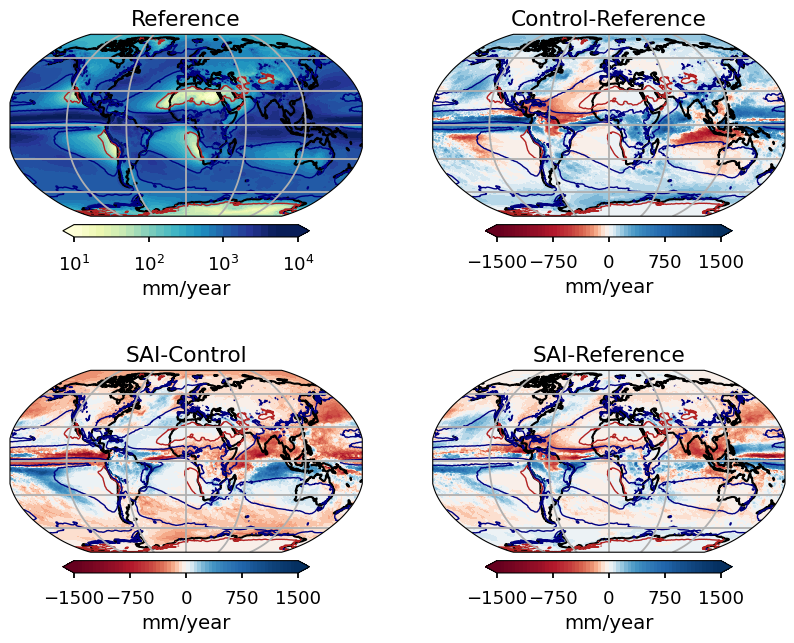

In [10]:
%%time
FAC = 1000*86400*365 # convert m/s to mm/year

figdata = {
    0: {'title': 'Reference',
        'cfdata': cam_EMTM['ref'],
        'cfkwargs': dict(norm=mcolors.LogNorm(vmin=10,vmax=5000), levels=np.power(10, np.arange(1,4.1,0.1)), cmap='YlGnBu'),
        'cbkwargs': dict(ticks=np.power(10, np.arange(1,4.1,0.1))[::10])},
    1: {'title': 'Control-Reference',
        'cfdata': cam_EMTM['cnt'] - cam_EMTM['ref'],
        'cfkwargs': dict(norm=mcolors.SymLogNorm(100, linscale=0.3), levels=np.arange(-1500,1501,50)),
        'cbkwargs': dict(ticks=np.arange(-1500,1501,750))},
    2: {'title': 'SAI-Control',
        'cfdata': cam_EMTM['sai'] - cam_EMTM['cnt'],
        'cfkwargs': dict(norm=mcolors.SymLogNorm(100, linscale=0.3), levels=np.arange(-1500,1501,50)),
        'cbkwargs': dict(ticks=np.arange(-1500,1501,750))},
    3: {'title': 'SAI-Reference',
        'cfdata': cam_EMTM['sai'] - cam_EMTM['ref'],
        'cfkwargs': dict(norm=mcolors.SymLogNorm(100, linscale=0.3), levels=np.arange(-1500,1501,50)),
        'cbkwargs': dict(ticks=np.arange(-1500,1501,750))},
}
    
fig, axs = plt.subplots(2,2, figsize=(10,8), subplot_kw={'projection':ccrs.Robinson()})

VARref = figdata[0]['cfdata'][VAR].mean('season') * FAC

for i,data in figdata.items():
    ax = axs.ravel()[i]
    ax.set_extent((-180,180,-90,90), crs=ccrs.PlateCarree())
    data = figdata[i]
    ds = data['cfdata']
    lons, lats = np.meshgrid(ds.lon, ds.lat)
    ax.coastlines(lw=1.5)
    gl = ax.gridlines()
    ax.set_title(data['title'])    
    VARavg = ds[VAR].mean('season') * FAC
    cf = ax.contourf(lons, lats, VARavg, **(dict(extend='both', cmap='RdBu', transform=ccrs.PlateCarree(), transform_first=True) | data['cfkwargs']))
    cs = ax.contour(lons, lats, VARref, levels=[100,1000], colors=['firebrick','navy'], linewidths=1, transform=ccrs.PlateCarree(), transform_first=True)
    fig.colorbar(cf, ax=ax, **(dict(orientation='horizontal', extend='both', shrink=0.7, pad=0.03, label='mm/year') | data['cbkwargs']))

In [11]:
def three_color_map(levs=[200,2000], Nlev=4, vmin=10, vmax=7000):
    """Custom colormap from three individual maps, logarithmic norm and colorbar ticks

    Input:
        levs: levels (data  coordinates) that separate the colormaps
        Nlev: cmap resolution: number of color levels between levs, result will have 3*Nlev colors
        vmin: lower colorbar limit (will be adjusted to make evenly spaced levels)
        vmax: upper colorbar limit (will be adjusted to make evenly spaced levels)

    Returns:
        cmap: colormap, combination of 'Oranges','Greens' and 'Blues', trimmed
        lognorm: logarithmic norm instance
        cbticks: 
    """
    # create levels 
    loglevels = np.power(10,np.linspace(np.log10(levs[0]**2/levs[1]),np.log10(levs[1]**2/levs[0]),Nlev*3+1))
    loglevels[loglevels<vmin] = np.nan
    loglevels[loglevels>vmax] = np.nan
    clevels = (loglevels[1:]+loglevels[:-1])/2
    loglevels = loglevels[~np.isnan(loglevels)]
    
    # colormap
    id0, id1 = [np.argmin(np.abs(np.array(loglevels)-lev)) for lev in levs]
    colors = np.concatenate([
        plt.get_cmap('Oranges')(np.linspace(0.1,0.4,id1-id0)),
        plt.get_cmap('Greens')(np.linspace(0.1,0.9,id1-id0)),
        plt.get_cmap('Blues')(np.linspace(0.4,0.9,id1-id0)),
    ])
    colors = colors[~np.isnan(clevels)]
    cmap = mcolors.ListedColormap(colors)
    cmap.set_under(plt.get_cmap('Oranges')(0.0))
    cmap.set_over(plt.get_cmap('Blues')(0.8))

    # norm
    vmin = np.min(loglevels)
    vmax = np.max(loglevels)
    lognorm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

    # colorbar ticks
    cbticks = np.array([i*(10**mult) for mult in range(-1,6) for i in range(1,10)])
    cbticks = cbticks[(cbticks>=vmin) * (cbticks<=vmax)]

    return loglevels, cmap, lognorm, cbticks

CPU times: user 3.81 s, sys: 179 ms, total: 3.99 s
Wall time: 3.84 s


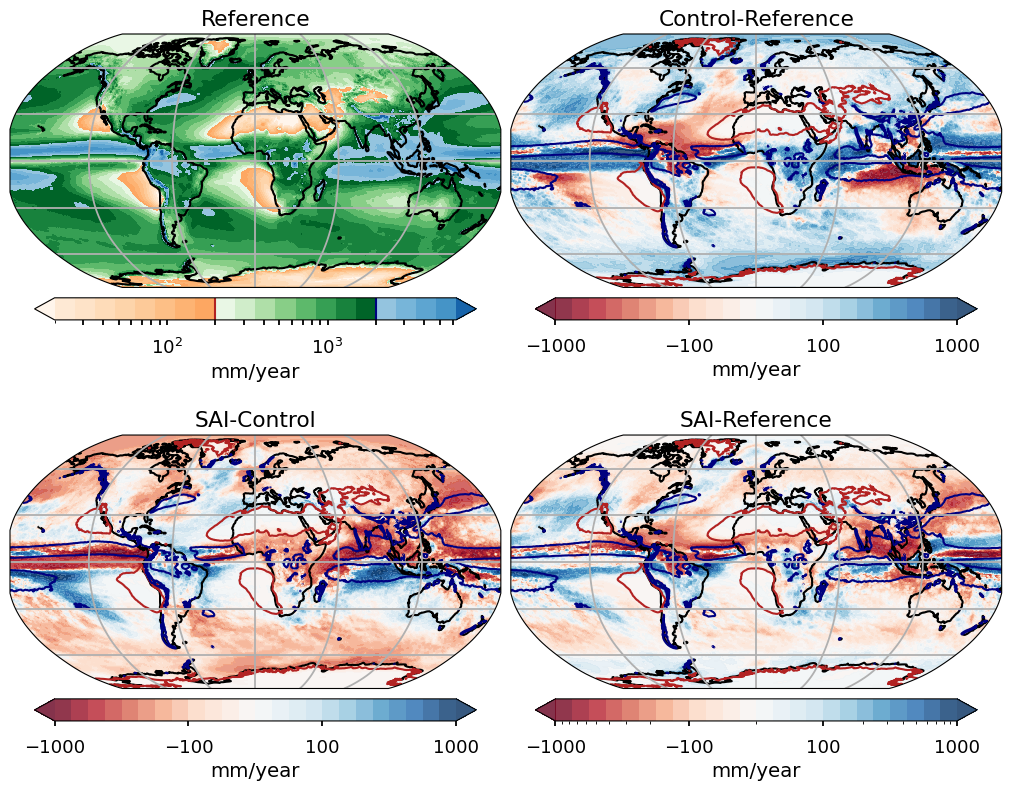

In [25]:
%%time
FAC = 1000*86400*365 # convert m/s to mm/year

loglevels, cmap, lognorm, cbticks = three_color_map(levs=[200,2000], Nlev=8, vmin=10, vmax=7000)
symlognorm = mcolors.SymLogNorm(100, linscale=0.3, vmin=-1000, vmax=1000)
symloglevels =[*np.arange(0,100,25), *np.power(10, np.linspace(np.log10(symlognorm.linthresh), np.log10(symlognorm.vmax), 9))]
symloglevels = [*-np.array(symloglevels)[-1:0:-1], *symloglevels]
symminorticks = [x*100 for x in range(-10,11)] #+ [x*10 for x in range(-10,9)] + [x*100 for x in range(1,11)]

figdata = {
    0: {'title': 'Reference',
        'cfdata': cam_EMTM['ref'],
        'cfkwargs': dict(norm=lognorm, levels=loglevels, cmap=cmap), #cmap='YlGnBu'),
        'cbkwargs': dict(ticks=cbticks)},
    1: {'title': 'Control-Reference',
        'cfdata': cam_EMTM['cnt'] - cam_EMTM['ref'],
        'cfkwargs': dict(norm=symlognorm, levels=symloglevels, alpha=0.8),
        'cbkwargs': dict(ticks=[-1000,-100,100,1000])},
    2: {'title': 'SAI-Control',
        'cfdata': cam_EMTM['sai'] - cam_EMTM['cnt'],
        'cfkwargs': dict(norm=symlognorm, levels=symloglevels, alpha=0.8),
        'cbkwargs': dict(ticks=[-1000,-100,100,1000])},
    3: {'title': 'SAI-Reference',
        'cfdata': cam_EMTM['sai'] - cam_EMTM['ref'],
        'cfkwargs': dict(norm=symlognorm, levels=symloglevels, alpha=0.8),
        'cbkwargs': dict(ticks=[-1000,-100,100,1000])},
}
    
fig, axs = plt.subplots(2,2, figsize=(10,8), layout='constrained', subplot_kw={'projection':ccrs.Robinson()})
VARref = figdata[0]['cfdata'][VAR].mean('season') * FAC

for i,data in figdata.items():
    ax = axs.ravel()[i]
    ax.set_extent((-180,180,-90,90), crs=ccrs.PlateCarree())
    data = figdata[i]
    ds = data['cfdata']
    # print(i,(ds[VAR]*FAC).quantile([0,0.01,0.99,1]).data)
    lons, lats = np.meshgrid(ds.lon, ds.lat)
    ax.coastlines(lw=1.5)
    gl = ax.gridlines()
    ax.set_title(data['title'])    
    VARavg = ds[VAR].mean('season') * FAC
    cf = ax.contourf(lons, lats, VARavg, **(dict(extend='both', cmap='RdBu', transform=ccrs.PlateCarree(), transform_first=True) | data['cfkwargs']))
    cb = fig.colorbar(cf, ax=ax, **(dict(orientation='horizontal', shrink=0.9, pad=0.03, label='mm/year') | data['cbkwargs']))
    if i==0:
        cb.ax.minorticks_on()
        cb.ax.axvline(200, c='firebrick', lw=1.5)
        cb.ax.axvline(2000, c='navy', lw=1.5)
    else:
        cs = ax.contour(lons, lats, VARref, levels=[200,2000], colors=['firebrick','navy'], linewidths=1.5, transform=ccrs.PlateCarree(), transform_first=True)
        cb.ax.set_xticks(symminorticks, minor=True)
    
        

0 annual, 1 annual, 2 annual, 3 annual, 0 MAM, 1 MAM, 2 MAM, 3 MAM, 0 JJA, 1 JJA, 2 JJA, 3 JJA, 0 SON, 1 SON, 2 SON, 3 SON, 0 DJF, 1 DJF, 2 DJF, 3 DJF, CPU times: user 15.5 s, sys: 391 ms, total: 15.9 s
Wall time: 15.6 s


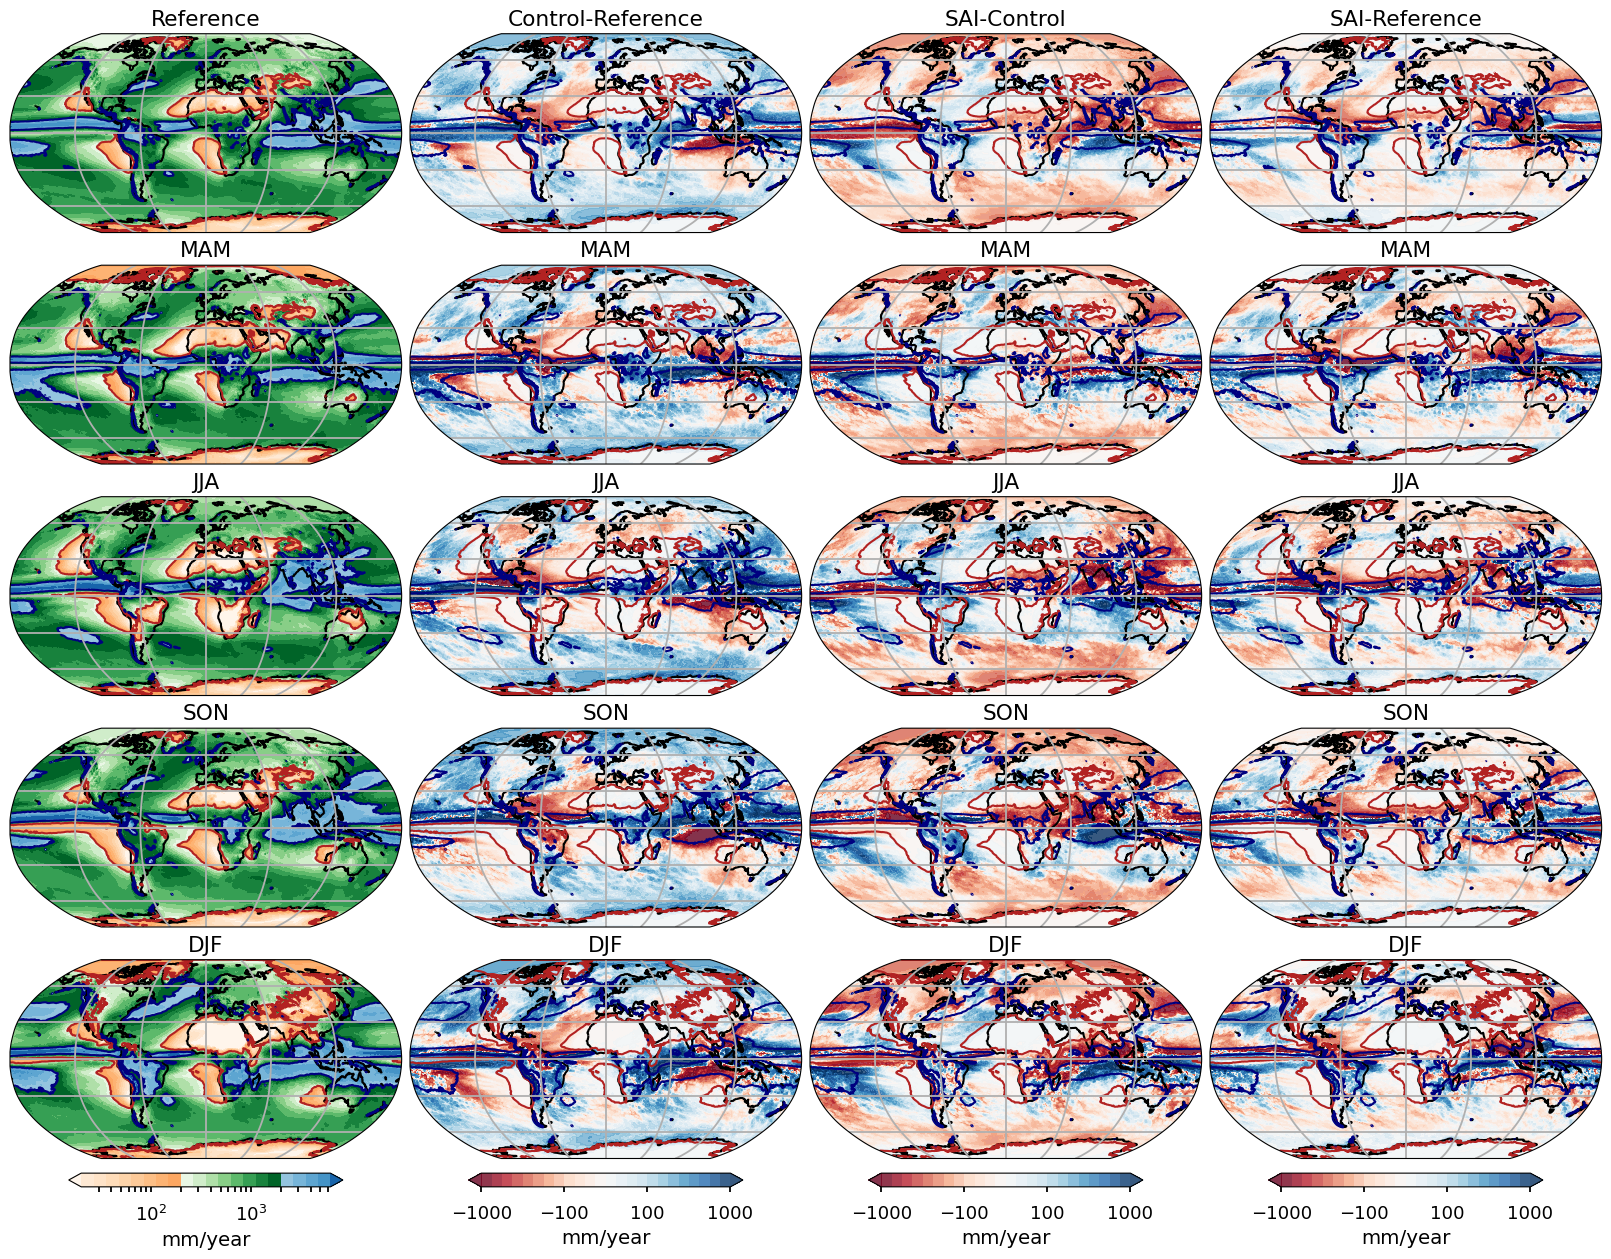

In [26]:
%%time
FAC = 1000*86400*365 # convert m/s to mm/year

loglevels, cmap, lognorm, cbticks = three_color_map(levs=[200,2000], Nlev=8, vmin=10, vmax=7000)
symlognorm = mcolors.SymLogNorm(100, linscale=0.3, vmin=-1000, vmax=1000)
symloglevels =[*np.arange(0,100,25), *np.power(10, np.linspace(np.log10(symlognorm.linthresh), np.log10(symlognorm.vmax), 9))]
symloglevels = [*-np.array(symloglevels)[-1:0:-1], *symloglevels]
symminorticks = [x*100 for x in range(-10,11)] #+ [x*10 for x in range(-10,9)] + [x*100 for x in range(1,11)]

figdata = {
    0: {'title': 'Reference',
        'cfdata': cam_EMTM['ref'],
        'cfkwargs': dict(norm=lognorm, levels=loglevels, cmap=cmap), #cmap='YlGnBu'),
        'cbkwargs': dict(ticks=cbticks)},
    1: {'title': 'Control-Reference',
        'cfdata': cam_EMTM['cnt'] - cam_EMTM['ref'],
        'cfkwargs': dict(norm=symlognorm, levels=symloglevels, alpha=0.8),
        'cbkwargs': dict(ticks=[-1000,-100,100,1000])},
    2: {'title': 'SAI-Control',
        'cfdata': cam_EMTM['sai'] - cam_EMTM['cnt'],
        'cfkwargs': dict(norm=symlognorm, levels=symloglevels, alpha=0.8),
        'cbkwargs': dict(ticks=[-1000,-100,100,1000])},
    3: {'title': 'SAI-Reference',
        'cfdata': cam_EMTM['sai'] - cam_EMTM['ref'],
        'cfkwargs': dict(norm=symlognorm, levels=symloglevels, alpha=0.8),
        'cbkwargs': dict(ticks=[-1000,-100,100,1000])},
}
    
fig, axs = plt.subplots(5,4, figsize=(16,14), layout='compressed', subplot_kw={'projection':ccrs.Robinson()})

for row, season in enumerate(('annual','MAM','JJA','SON','DJF')):
    VARref = figdata[0]['cfdata'][VAR]
    VARref = VARref.mean('season') if season=='annual' else VARref.sel(season=season)
    for col, data in list(figdata.items())[:]:
        ds = data['cfdata']
        ax = axs[row,col]
        print(col, season, end=', ')
        ax.coastlines(lw=1.5)
        ax.gridlines()
        VARavg = ds[VAR].mean('season') if season=='annual' else ds[VAR].sel(season=season)
        cf = ax.contourf(lons, lats, VARavg*FAC, **(dict(extend='both', cmap='RdBu', transform=ccrs.PlateCarree(), transform_first=True) | data['cfkwargs']))
        cs = ax.contour(lons, lats, VARref*FAC, levels=[200,2000], colors=['firebrick','navy'], linewidths=1.5, transform=ccrs.PlateCarree(), transform_first=True)
        ax.set_title(data['title'] if season=='annual' else season)
        if row == 4:
            fig.colorbar(cf, ax=axs[row,col], **(dict(orientation='horizontal', extend='both', shrink=0.7, label='mm/year') | data['cbkwargs']))

In [75]:
fig.savefig('../../fig/PRECT.maps.png', dpi=300)

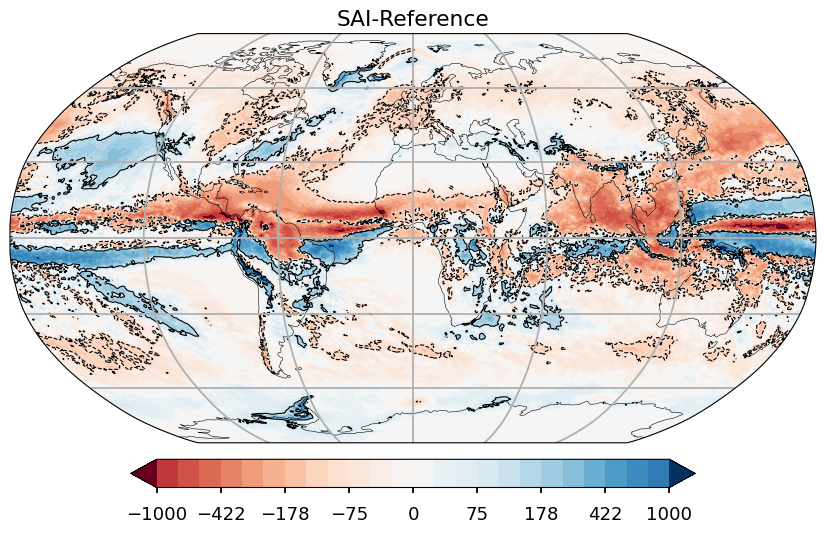

In [34]:
FAC = 1000*86400*365 # convert m/s to mm/year

loglevels, cmap, lognorm, cbticks = three_color_map(levs=[200,2000], Nlev=8, vmin=10, vmax=7000)
symlognorm = mcolors.SymLogNorm(100, linscale=0.3, vmin=-1000, vmax=1000)
symloglevels =[*np.arange(0,100,25), *np.power(10, np.linspace(np.log10(symlognorm.linthresh), np.log10(symlognorm.vmax), 9))]
symloglevels = [*-np.array(symloglevels)[-1:0:-1], *symloglevels]
symminorticks = [x*100 for x in range(-10,11)]

figdata = {
    0: {'title': 'Reference',
        'cfdata': cam_EMTM['ref'],
        'cfkwargs': dict(norm=mcolors.LogNorm(vmin=10,vmax=5000), cmap='YlGnBu', transform=ccrs.PlateCarree())},
    1: {'title': 'Control-Reference',
        'cfdata': cam_EMTM['cnt'] - cam_EMTM['ref'],
        'cfkwargs': dict(norm=mcolors.SymLogNorm(100, linscale=0.3, vmin=-3000,vmax=3000), cmap='RdBu', transform=ccrs.PlateCarree())},
    2: {'title': 'SAI-Control',
        'cfdata': cam_EMTM['sai'] - cam_EMTM['cnt'],
        'cfkwargs': dict(norm=mcolors.SymLogNorm(100, linscale=0.3, vmin=-3000,vmax=3000), cmap='RdBu', transform=ccrs.PlateCarree())},
    3: {'title': 'SAI-Reference',
        'cfdata': cam_EMTM['sai'] - cam_EMTM['ref'],
        'cfkwargs': dict(norm=mcolors.SymLogNorm(100, linscale=0.3, vmin=-3000,vmax=3000), cmap='RdBu', transform=ccrs.PlateCarree())},
}

ax = plt.axes(projection=ccrs.Robinson())

col = 3
data = figdata[col]
ds = data['cfdata']
lons, lats = np.meshgrid(ds.lon, ds.lat)
season = ('annual','MAM','JJA','SON','DJF')[0]
ax.coastlines()
ax.gridlines()
ax.set_title(data['title'] if season=='annual' else season)    
VARavg = ds[VAR].mean('season') if season=='annual' else ds[VAR].sel(season=season)
cf = ax.contourf(lons, lats, VARavg*FAC, norm=mcolors.SymLogNorm(100, linscale=0.3, vmin=-3000,vmax=3000), 
                 levels=symloglevels, extend='both', cmap='RdBu', transform=ccrs.PlateCarree(), transform_first=True)
cs = ax.contour(lons, lats, VARavg*FAC, levels=[-100,100], linewidths=0.8, linestyles=['--','-'], colors=['k','k'], transform=ccrs.PlateCarree(), transform_first=True)
cb = plt.colorbar(cf, orientation='horizontal', shrink=0.7, pad=0.03, extend='both')
#cb.ax.axvline(100, lw=0.8, c='red')
#cb.ax.axvline(1000, lw=0.8, c='blue')
# minorticks = list(range(1,10))+list(range(10,100,10))+list(range(100,1000,100))+list(range(1000,10000,1000))
# _=cb.ax.set_xticks(minorticks, minor=True)
#_=cb.ax.set_xticks([-1000,-500,0,500,1000])